In [1]:
import pickle
from pathlib import Path
import numpy as np
import gurobipy as gp; gp.Model()
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from src.input import Input_uc
from src.output import Output_uc
from src.unit_commitment import solve_uc_formulation_0, solve_uc_formulation_1

Set parameter Username
Set parameter LicenseID to value 2659802
Academic license - for non-commercial use only - expires 2026-05-01


In [2]:
num_units = 122
num_periods = 24 * 2
time_start, time_end = np.datetime64("2022-07-02T00"), np.datetime64("2022-07-03T23")

In [3]:
path_folder_processed = Path.cwd() / "data" / "input" / "processed"
timestamp_2022 = np.load(path_folder_processed / "timestamp_2022.npy")
idx_time_start, idx_time_end = np.where(timestamp_2022 == time_start)[0][0], np.where(timestamp_2022 == time_end)[0][0]
idx_time_prev = idx_time_start - 1
if idx_time_prev < 0:
    raise NotImplementedError("not 2022-01-01T00 for the time start")

In [4]:
unit_type = np.load(path_folder_processed / "unit_type.npy")
idx_nuclear = np.load(path_folder_processed / "idx_nuclear.npy")
idx_coal = np.load(path_folder_processed / "idx_coal.npy")
idx_lng = np.load(path_folder_processed / "idx_lng.npy")
p_min = np.load(path_folder_processed / "p_min.npy")
p_max = np.load(path_folder_processed / "p_max.npy")
ramp_up = np.load(path_folder_processed / "ramp_up.npy")
ramp_down = np.load(path_folder_processed / "ramp_down.npy")
startup_ramp = np.load(path_folder_processed / "startup_ramp.npy")
shutdown_ramp = np.load(path_folder_processed / "shutdown_ramp.npy")
min_up = np.load(path_folder_processed / "min_up.npy")
min_down = np.load(path_folder_processed / "min_down.npy")
cost_lin = np.load(path_folder_processed / "cost_lin.npy")
cost_const = np.load(path_folder_processed / "cost_const.npy")

In [5]:
cost_startup_step_formulation_0 = pickle.load(open(path_folder_processed / "cost_startup_step_formulation_0.pkl", "rb"))
num_cooling_steps_formulation_0 = np.load(path_folder_processed / "num_cooling_steps_formulation_0.npy")
cost_startup_step_formulation_1 = np.load(path_folder_processed / "cost_startup_step_formulation_1.npy")
step_length_formulation_1 = np.load(path_folder_processed / "step_length_formulation_1.npy")

In [6]:
demand_2022 = np.load(path_folder_processed / "demand_2022.npy")
demand = demand_2022[idx_time_start:idx_time_end+1]

In [7]:
# mustoff_2022 = np.load(path_folder_processed / "mustoff_2022.npy")

In [8]:
renewable_2022 = np.load(path_folder_processed / "renewable_2022.npy")
renewable = renewable_2022[idx_time_start:idx_time_end+1]

In [9]:
status_2022 = np.load(path_folder_processed / "status_2022.npy")
u_prev = status_2022[:, idx_time_start-num_cooling_steps_formulation_0.max():idx_time_start]

In [10]:
# for TA marking: you can check like this easily for init condition correctness
# for idx_unit, (u_prev_i, min_up_i) in enumerate(zip(u_prev, min_up)):
#     summm = sum(u_prev_i[-min_up_i:])
#     if summm not in (0, min_up_i):
#         print(idx_unit, u_prev_i[-min_up_i:])

# for idx_unit, (u_prev_i, min_down_i) in enumerate(zip(u_prev, min_down)):
#     summm = sum(u_prev_i[-min_down_i:])
#     if summm not in (0, min_down_i):
#         print(idx_unit, u_prev_i[-min_down_i:])

def _tail_count(seq, value):
    cnt = 0
    for x in reversed(seq):
        if x == value:
            cnt += 1
        else:
            break
    return cnt

min_up_r, min_down_r = [], []
for hist, mu, md in zip(u_prev, min_up, min_down):
    on_tail  = _tail_count(hist, 1)
    off_tail = _tail_count(hist, 0)

    if on_tail:
        min_up_r.append(max(0, mu - on_tail))
        min_down_r.append(0)
    else:
        min_up_r.append(0)
        min_down_r.append(max(0, md - off_tail))

min_up_r, min_down_r = np.array(min_up_r).astype(np.int64), np.array(min_down_r).astype(np.int64)

In [11]:
def _tail_count(seq, value):
    cnt = 0
    for x in reversed(seq):
        if x == value:
            cnt += 1
        else:
            break
    return cnt

min_up_0 = np.array(
    [_tail_count(u_prev[g], 1) for g in range(num_units)], dtype=np.int64
)
min_down_0 = np.array(
    [_tail_count(u_prev[g], 0) for g in range(num_units)], dtype=np.int64
)

---
---
---

In [12]:
idx_u_prev_up = u_prev[:, -1].astype(bool)
p_prev = np.zeros(num_units)
p_prev[idx_u_prev_up] = p_min[idx_u_prev_up]

In [13]:
input_uc = Input_uc(
    unit_type=unit_type,
    idx_nuclear=idx_nuclear,
    idx_coal=idx_coal,
    idx_lng=idx_lng,

    
    num_units=num_units,
    num_periods=num_periods,
    #########################
    demand=demand,
    # np.linspace(p_min.sum(), p_max.sum() - (p_max[idx_coal] - p_min[idx_coal]).sum(), num_periods), # demand,
    reserve=(demand - renewable) * 0.3,
    # np.full((num_periods), (p_max[idx_coal] - p_min[idx_coal]).sum()), # (demand - renewable) * 0.05,
    renewable=renewable,
    # np.zeros((num_periods)), # renewable,
    #########################
    p_min=p_min,
    p_max=p_max,
    ramp_up=ramp_up,
    ramp_down=ramp_down,
    startup_ramp=startup_ramp,
    shutdown_ramp=shutdown_ramp,
    min_up=min_up,
    min_down=min_down,
    #########################
    cost_lin=cost_lin,
    cost_const=cost_const,
    #########################
    cost_startup_step_formulation_0=cost_startup_step_formulation_0,
    num_cooling_steps_formulation_0=num_cooling_steps_formulation_0,
    cost_startup_step_formulation_1=cost_startup_step_formulation_1,
    step_length_formulation_1=step_length_formulation_1,
    #########################
    p_prev=p_prev,
    u_prev=u_prev,
    min_up_r=min_up_r,
    min_down_r=min_down_r,
    min_up_0=min_up_0,
    min_down_0=min_down_0,
)

---
---
---

In [14]:
output_uc_1 = Output_uc()
model, constr_generation, constr_reserve,constr_ramp_1, constr_ramp_2, constr_ramp_3, constr_ramp_4 = solve_uc_formulation_1(input_uc=input_uc, output_uc=output_uc_1, verbose=True, test=False)

Set parameter OutputFlag to value 1
Set parameter Symmetry to value 2
Set parameter PreDual to value 2
Set parameter Presolve to value 1
Set parameter PreSparsify to value 2
Set parameter Disconnected to value 2
Set parameter Heuristics to value 1
Set parameter ProjImpliedCuts to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
Disconnected  2
Heuristics  1
Symmetry  2
ProjImpliedCuts  2
PreDual  2
Presolve  1
PreSparsify  2

Optimize a model with 75432 rows, 46848 columns and 321492 nonzeros
Model fingerprint: 0xdbe6d386
Variable types: 11712 continuous, 35136 integer (35136 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+03, 6e+07]
  Bounds range     [1e+00, 7e+02]
  RHS range        [1e+00, 7e+04]
Sparsify removed 8487 nonzeros 

In [15]:
def plot_heatmap(input_uc: Input_uc, output_uc: Output_uc, fig_height: float = 20, pad_rectangle: float = None):
    cmap = plt.cm.jet.copy()
    cmap.set_bad(color="white")
    num_periods = output_uc.p.shape[1]

    idx_marginal_unit_per_period = np.array([
        int(np.where(input_uc.cost_lin == mpg)[0][0]) 
        if mpg > 0 else -2 # for test (demand = 0 to blackstart) result plot purpose
        for mpg in output_uc.marginal_price_generation
        ])

    helper = [
        (input_uc.idx_lng, len(input_uc.idx_nuclear) + len(input_uc.idx_coal)),
        (input_uc.idx_coal, len(input_uc.idx_nuclear)),
        (input_uc.idx_nuclear, 0),
    ]

    idx_constrained_by_ramp_mat = np.zeros((num_units, num_periods), dtype=np.int64)
    for i in range(num_units):
        for t in range(num_periods):

            if t == num_periods - 1:
                idx_constrained_by_ramp_mat[i, t] = bool(constr_ramp_2[i, t].Pi)
                continue

            idx_constrained_by_ramp_mat[i, t] = bool(constr_ramp_1[i, t].Pi) or bool(constr_ramp_3[i, t].Pi) or bool(constr_ramp_4[i, t].Pi)
    idx_constrained_by_ramp_mat = idx_constrained_by_ramp_mat.transpose()
    
    
    fig, axes = plt.subplots(3, 1, figsize=(fig_height, fig_height), gridspec_kw={"height_ratios": [56/122, 41/122, 25/122]}, sharex=True)

    for ax, (idx_type, idx_start) in zip(axes, helper):
        p_type = output_uc.p[idx_type]
        num_units_type = len(p_type)
        p_min_type = np.tile(input_uc.p_min[idx_type][:, None], reps=num_periods)
        p_max_type = np.tile(input_uc.p_max[idx_type][:, None], reps=num_periods)
        heatmap = (p_type - p_min_type) / (p_max_type - p_min_type) * 100
        heatmap[p_type == 0] = np.nan

        #
        ax.imshow(
            heatmap,
            aspect="auto",
            origin="lower",
            extent=[0.5, input_uc.num_periods + 0.5, idx_start, idx_start + num_units_type],
            cmap=cmap,
            vmin=0,
            vmax=100,
        )
        
        #
        pad_rectangle = 0.066 / 20 * fig_height if pad_rectangle is None else pad_rectangle
        for t in range(num_periods):
            u_abs = idx_marginal_unit_per_period[t]
            if idx_start <= u_abs < idx_start + num_units_type:

                rect_h = Rectangle(
                    (t + 0.5 + pad_rectangle, u_abs), 1 - 2 * pad_rectangle, 1,
                    fill=False,
                    edgecolor="white",
                    facecolor="none",
                    hatch="///",
                    linewidth=0,
                    zorder=3
                )
                rect_h.set_hatch_linewidth(fig_height / 10)
                ax.add_patch(rect_h)

                ax.add_patch(
                    Rectangle(
                        (t + 0.5 + pad_rectangle, u_abs), 1 - 2 * pad_rectangle, 1,
                        fill=False,
                        edgecolor="black",
                        facecolor="none",
                        # hatch="//",
                        linewidth=fig_height / 5,
                        zorder=3
                    )
                )
            for idx_unit, val in enumerate(idx_constrained_by_ramp_mat[t]):
                if val:
                    if idx_start <= val < idx_start + num_units_type:
                        rect_h = Rectangle(
                            (t + 0.5 + pad_rectangle, idx_unit), 1 - 2 * pad_rectangle, 1,
                            fill=False,
                            edgecolor="white",
                            facecolor="none",
                            hatch="\\",
                            linewidth=0,
                            zorder=3
                        )
                        rect_h.set_hatch_linewidth(fig_height / 10)
                        ax.add_patch(rect_h)


        #
        ax.set_yticks([idx_start, idx_start + num_units_type - 1])
        ax.set_yticklabels([idx_start + 1, idx_start + num_units_type])
        ax.tick_params(axis="both", width=fig_height / 10, length=fig_height / 2, pad=fig_height / 2, labelsize=fig_height * 2)
        for side in ["bottom", "left", "top", "right"]:
            ax.spines[side].set_linewidth(fig_height / 10)

    xticks_temp = np.arange(0, num_periods + 1, 6)
    xticks_temp[0] = 1
    axes[-1].set_xticks(xticks_temp)
    axes[-1].set_xticklabels(xticks_temp)

    # axes[-2].hlines(y=57, xmin=1, xmax=24, colors="black", ls="--") # for TA: you can test like this the 57th (0-based) idx unit will be shown

    plt.tight_layout()
    plt.show(fig)

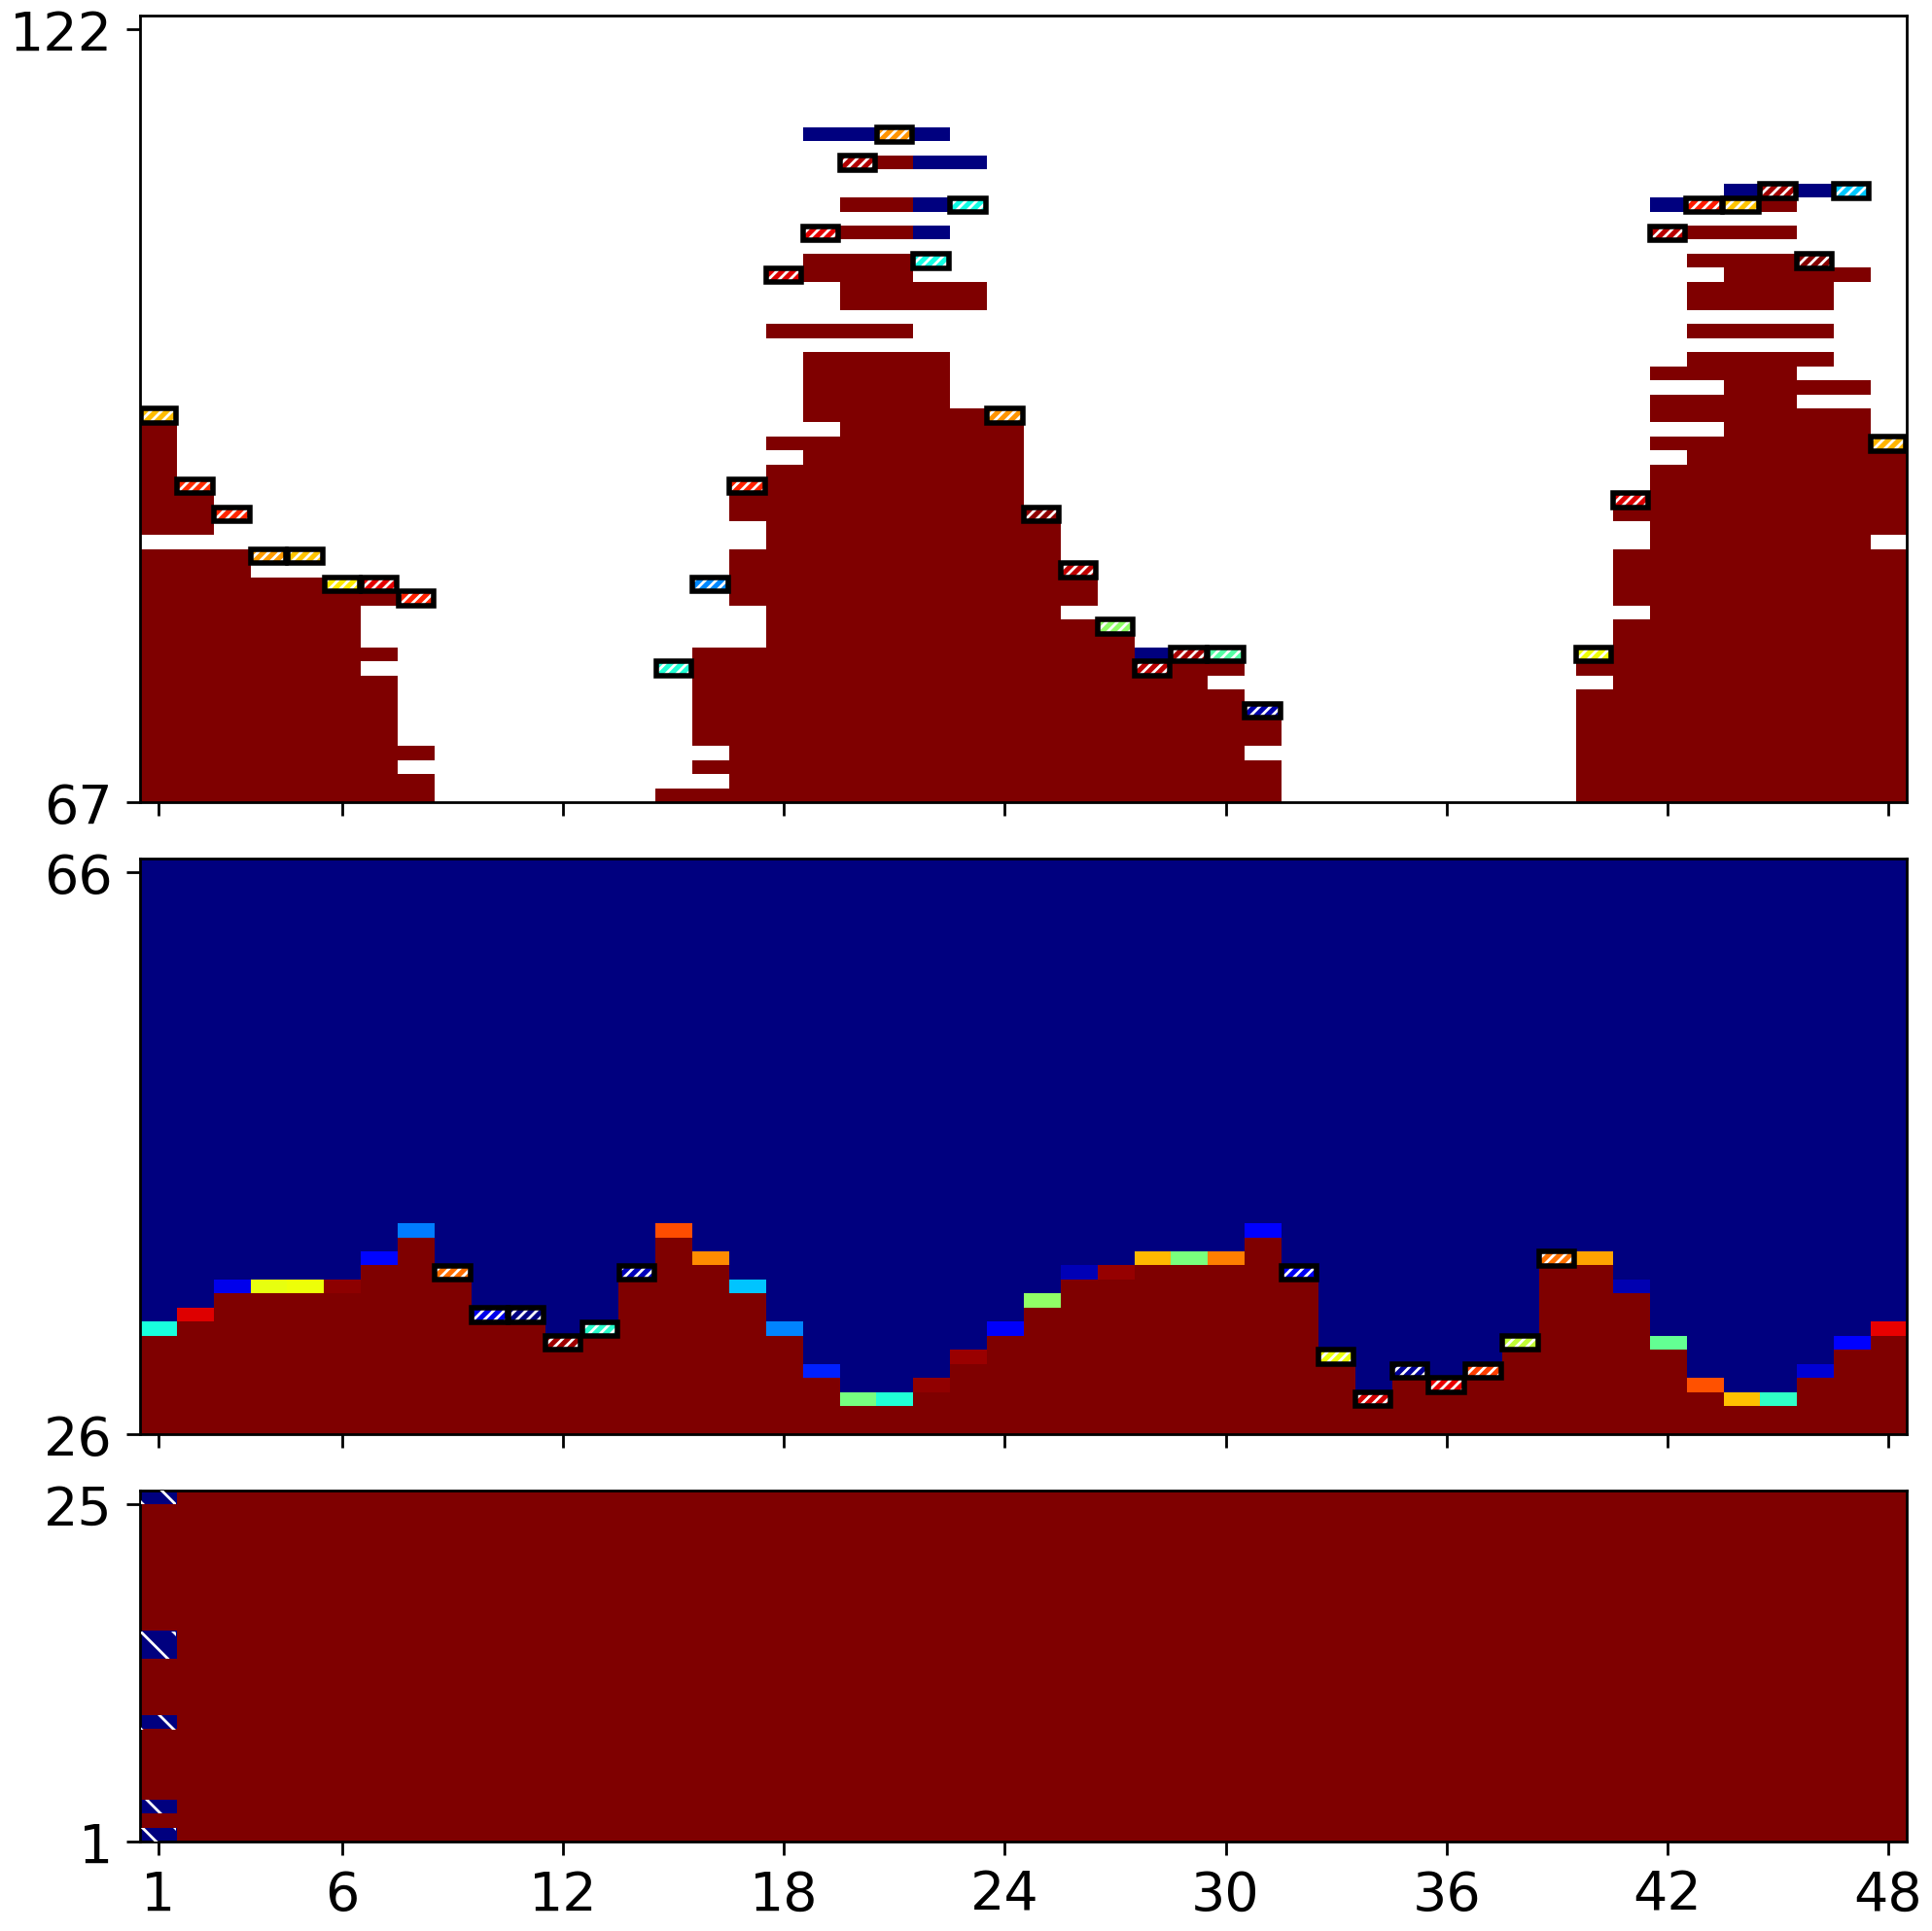

In [16]:
plot_heatmap(input_uc=input_uc, output_uc=output_uc_1, fig_height=20, pad_rectangle=0.02)

In [17]:
output_uc_1.marginal_price_reserve

array([28422.88221, 27105.59414, 26697.84256, 26533.63074, 26533.63074,
       26384.53969, 26303.6943 , 25884.2665 ,     0.     ,     0.     ,
           0.     ,     0.     ,     0.     ,     0.     , 24407.74384,
       26303.6943 , 27015.71324, 33980.40435, 34852.10007, 39001.93008,
       40833.45589, 34586.32259, 34931.31617, 28422.88221, 26704.99894,
       26441.31793, 26114.56774, 24765.44381, 24986.64811, 24986.64811,
       24194.47076,     0.     ,     0.     ,     0.     ,     0.     ,
           0.     ,     0.     ,     0.     ,     0.     , 24986.64811,
       26860.21406, 34591.72702, 35096.11219, 35358.15269, 36990.71336,
       34556.90469, 36438.88191, 28086.83228])

In [19]:
arr_bool = []
for t in range(num_periods):
    oc_temp = output_uc_1.marginal_price_generation[t] - input_uc.cost_lin
    oc = np.array([max(0, oc_i) for oc_i in oc_temp])
    arr_bool.append(oc[np.where(output_uc_1.r[:, t] != 0)[0][0]] == output_uc_1.marginal_price_reserve[t])

np.all(np.array(arr_bool))

np.True_